In [1]:
import os, sys
from os.path import abspath, dirname
import zarr
import z5py
import numpy as np
import pandas as pd
from glob import glob 
from skimage.measure import regionprops
from skimage.io import imread, imsave
from scipy import stats
from scipy.stats import skewnorm, lognorm
from scipy.optimize import minimize
import itertools
import collections

sys.path.append('../../')
from easi_fish import n5_metadata_utils as n5mu
from easi_fish import roi_prop, spot, intensity
import warnings
warnings.filterwarnings('ignore')

import importlib
importlib.reload(spot)
importlib.reload(roi_prop)
importlib.reload(intensity)

<module 'easi_fish.intensity' from '/u/project/zipursky/f7xiesnm/code/easifish-proc/bydatasets/sparse06/../../easi_fish/intensity.py'>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

sns.set_style('white', rc={'axes.grid':True})
sns.set_context('talk')

Spot counts for cells with highly expressed genes (dense spots)
1. Measure total intensity of every ROI after bleed-through correction and background subtraction.
2. Calculate the number of spot from total intensity based on unit-spot intensity
3. Correlate the number of spots (from air-localize) with the total fluorescence intensity/voxel in each ROI and determine a 'cutoff'. 
   Spot count > cutoff: use spot count converted based on total fluorescence intensity; 
   Spot count < cutoff: use spot count from Airlocalize

### On units
- all images are based on pixel units - 
- roi meta file (output) are based on physical unit (um - pre-expansion)
- spots files are in um (post-expansion)

In [4]:
ddir = '/u/home/f/f7xiesnm/project-zipursky/easifish/sparse06'
output_dir = ddir + '/proc/r1-v2-1'
!mkdir -p $output_dir
!ls $output_dir

roi_all.csv  roi.csv  spotcount.csv


In [5]:
## input

# theround = 'r2'
# rounds = [theround]
# channels = ['c0', 'c1', 'c2', 'c4']


fix_round = 'r1'
mov_rounds = [] #['r2', 'r6', 'r7']
round_channels = collections.OrderedDict({
    'r1': ('c0', 'c2', 'c4'),
})

dapi_channel = 'c3'
lb_scale = 's3'
lb_res = [1.84,1.84,1.68]
ex = 2

# images
fix_dir  =  ddir + f"/outputs/{fix_round}/stitching/export.n5"
lb_dir  =   ddir + f"/outputs/{fix_round}/segmentation/{fix_round}-{dapi_channel}.tif"
reg_dirs = []
# reg_dirs = [
#     ddir + f"/outputs/r2/registration/usable/r2-to-r1/warped",
#     ddir + f"/outputs/r7/registration/usable/r7-to-r1/warped",
#     ]
subpath =   f'/{dapi_channel}/{lb_scale}' 


# spot dir for every gene
fx_spots = [
    ddir + f'/outputs/r1/spots/spots_c0.txt',
    ddir + f'/outputs/r1/spots/spots_c2.txt',
    ddir + f'/outputs/r1/spots/spots_c4.txt',
]


# intn_threshs = [
#     150, 
#     150, 
#     150, 
# ]

intn_threshs = [
    100, 
    100, 
    100, 
]
    
for f in fx_spots:
    assert os.path.isfile(f)

## output
out_badroi = os.path.join(output_dir, 'bad_roi_list.npy')
out_allroi = os.path.join(output_dir, "roi_all.csv") 
out_roi = os.path.join(output_dir, "roi.csv") 
out_spots = os.path.join(output_dir, "spotcount.csv")

In [6]:
f_gcamp = ddir +  f'/outputs/r1/intensities/r1_c1_intensity.csv' 
df_gcamp = pd.read_csv(f_gcamp)
df_gcamp

,roi,weighted_centroid,weighted_local_centroid,mean_intensity
0,1,2.361220e-310,4.640336e-310,90.028198
1,2,5.562987e-307,5.562987e-307,90.157022
2,3,5.562990e-307,5.562987e-307,95.789548
3,4,5.562990e-307,6.008005e-307,88.729637
4,5,5.785498e-307,5.785501e-307,90.787868
...,...,...,...,...
36217,36218,5.562990e-307,5.340476e-307,74.216888
36218,36219,5.562983e-307,5.562987e-307,88.531509
36219,36220,5.562987e-307,5.340476e-307,90.439289
36220,36221,5.562987e-307,5.562987e-307,86.373626


In [7]:
df1 = pd.read_csv(fx_spots[0], header=None)
df1

,0,1,2,3
0,7.144904,1.165686,1.135722,90.6982
1,7.234512,4.902588,0.824292,92.5926
2,9.455622,6.734722,0.969738,90.9669
3,13.569678,1.640406,0.858606,89.7147
4,10.775178,2.018894,1.158318,92.0996
...,...,...,...,...
8459745,2276.732643,1815.399693,1190.463587,88.3649
8459746,2282.732929,1812.602203,1190.360729,89.0678
8459747,2281.821255,1814.026087,1190.404325,89.0570
8459748,2282.249239,1819.944355,1190.403653,89.6527


<Axes: xlabel='3', ylabel='Count'>

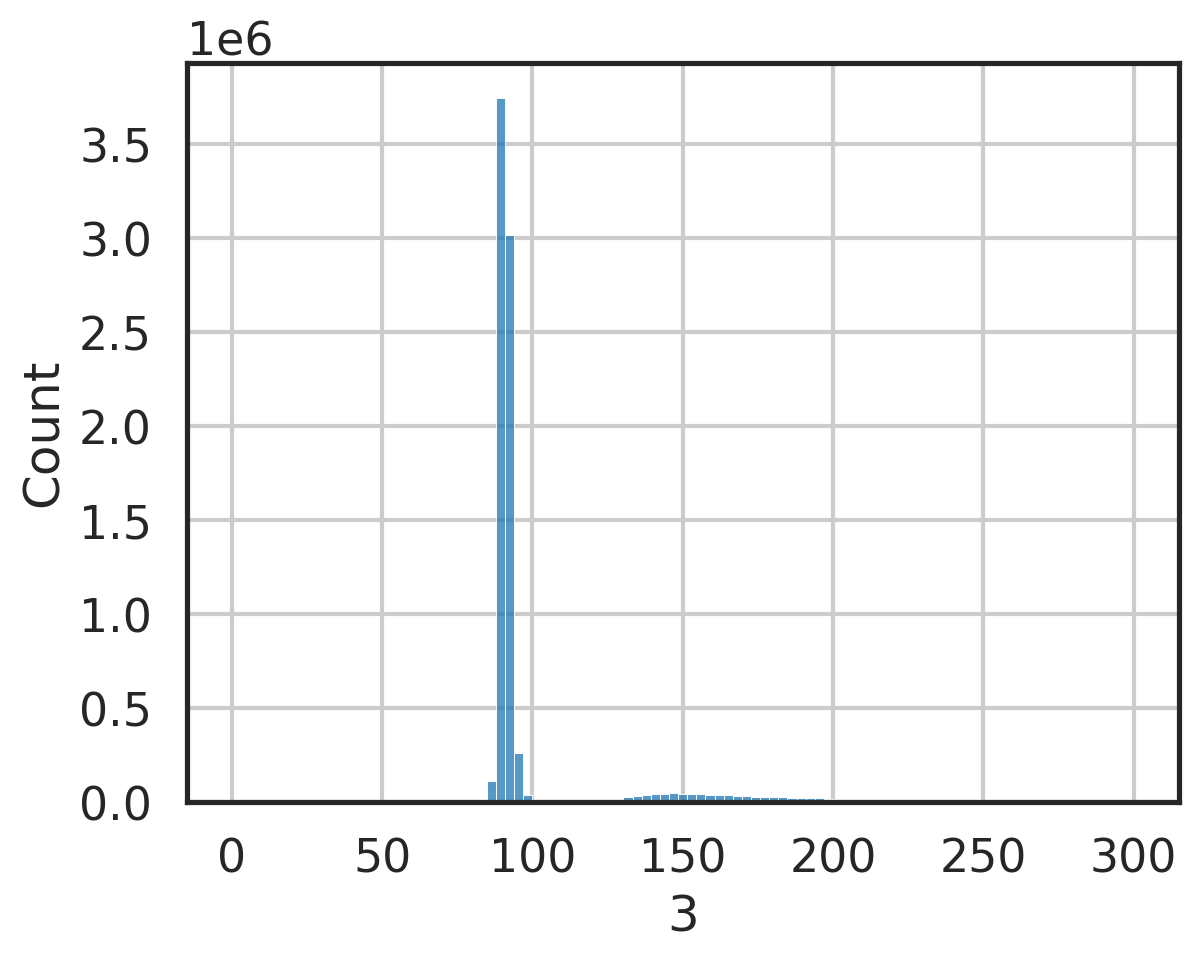

In [20]:
bins = np.linspace(0, 300, 100)
sns.histplot(df1[3], bins=bins)

In [10]:
# df1sub = df1[df1[3]<200]

In [26]:
nbins = ((df1[[0,1,2]].max() - df1[[0,1,2]].min())/40).astype(int)
nbins

0    57
1    45
2    31
dtype: int64

In [34]:
print(df1.shape)
th = 100
df1 = df1[df1[3] > th]
print(df1.shape)

(8459750, 7)
(1267459, 7)


In [39]:
df1['xbin'] = pd.cut(df1[0], nbins.loc[0], labels=False)
df1['ybin'] = pd.cut(df1[1], nbins.loc[1], labels=False)
df1['zbin'] = pd.cut(df1[2], nbins.loc[2], labels=False)

count1_xy = df1.groupby(['xbin', 'ybin']).size().unstack().T
count1_xz = df1.groupby(['xbin', 'zbin']).size().unstack().T
count1_yz = df1.groupby(['ybin', 'zbin']).size().unstack().T

Text(0.5, 1.0, 'before')

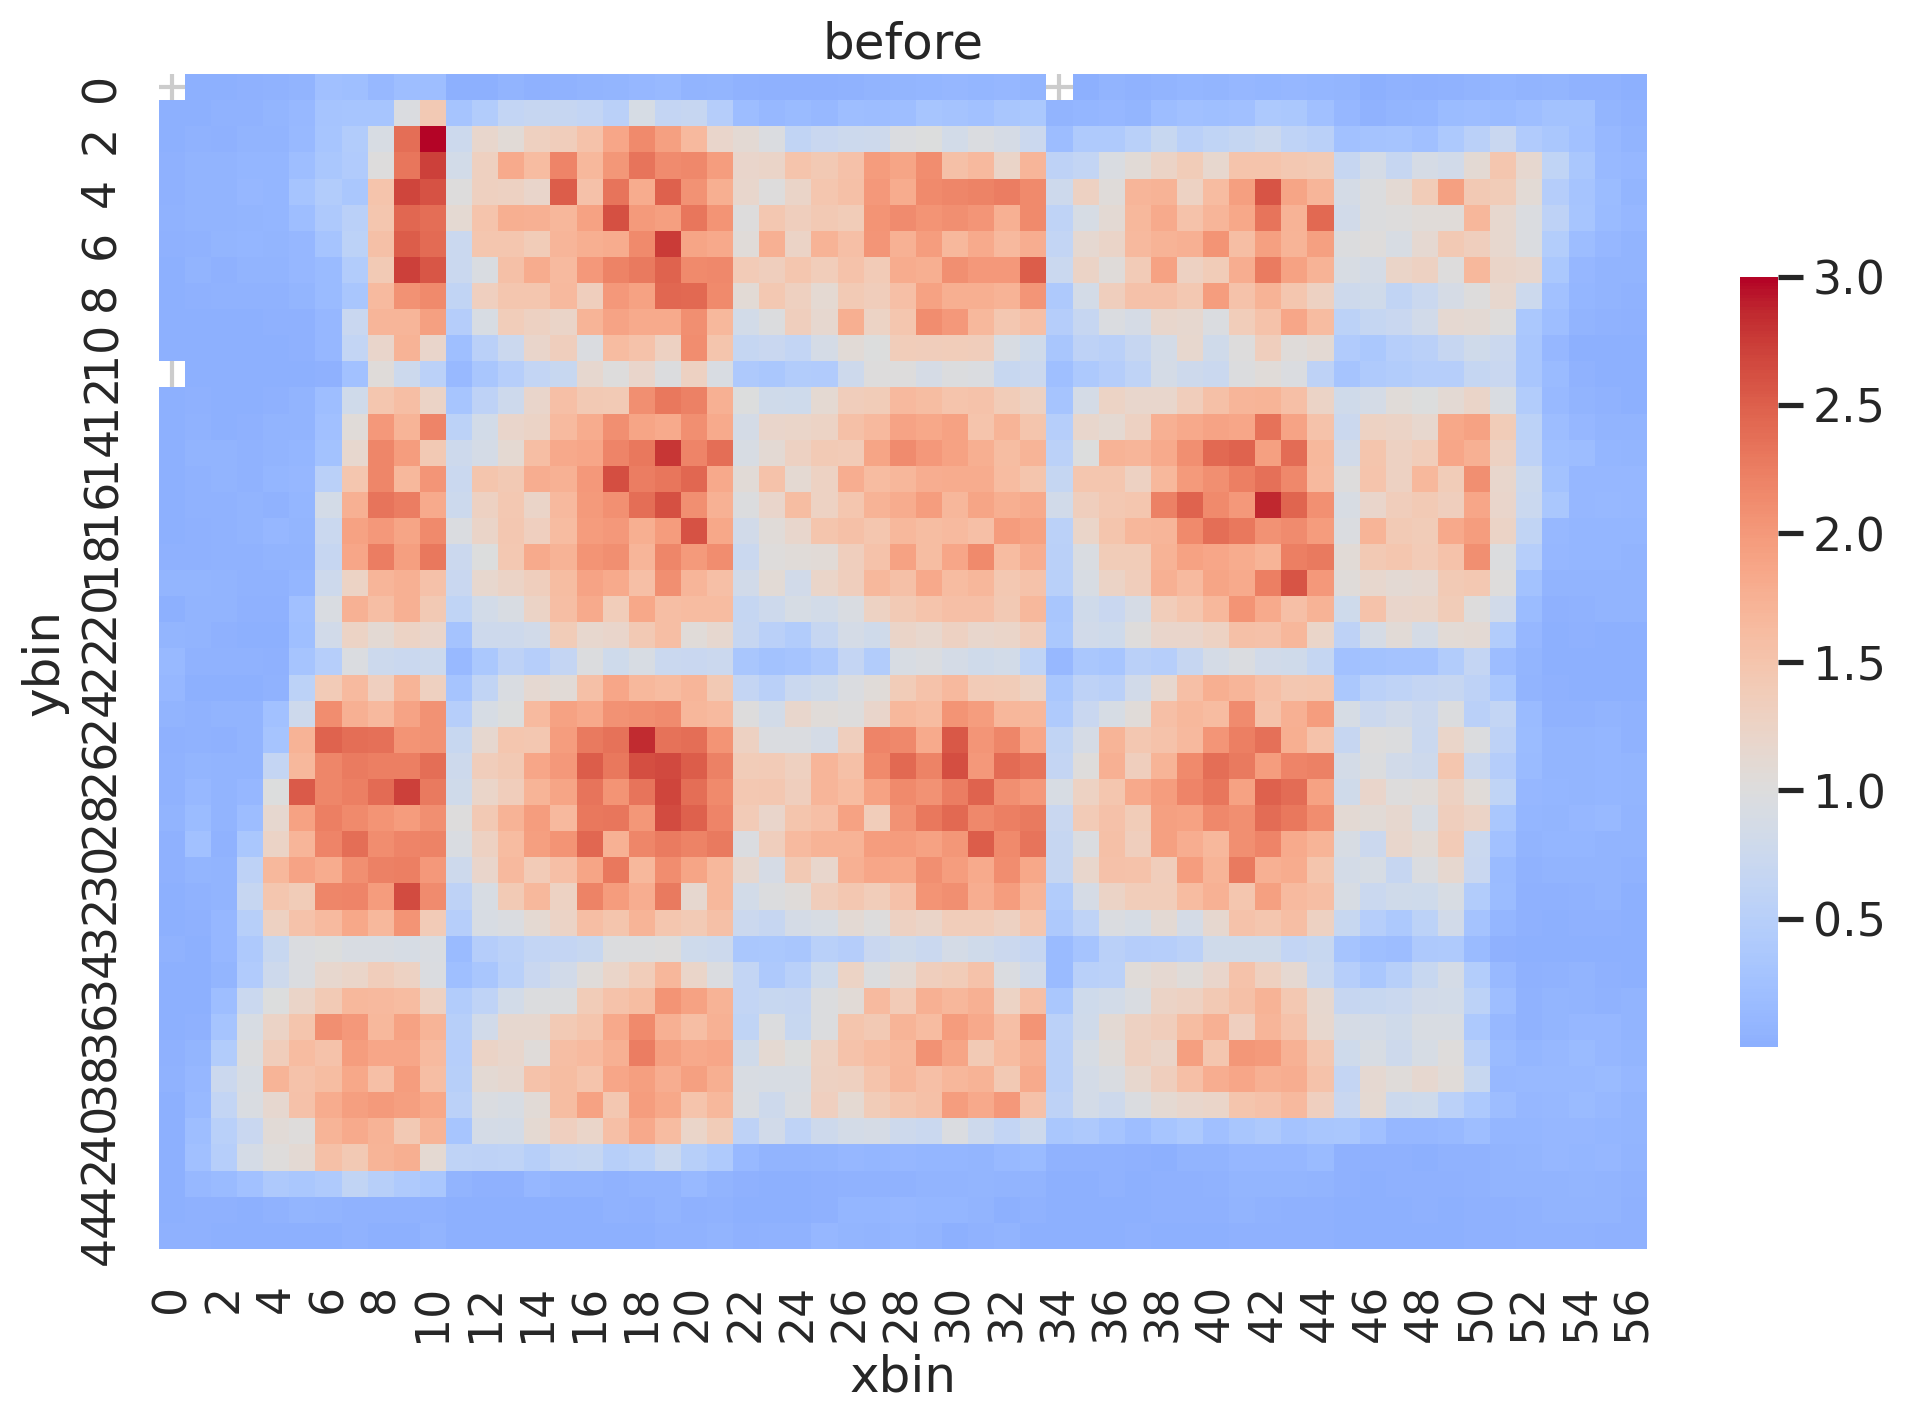

In [45]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
sns.heatmap(count1_xy/np.nanmean(count1_xy.values), ax=ax, cbar_kws=dict(shrink=0.5), cmap='coolwarm', center=1, vmax=3) #, vmax=2)
ax.set_aspect('equal')
ax.set_title('before')

Text(0.5, 1.0, 'before')

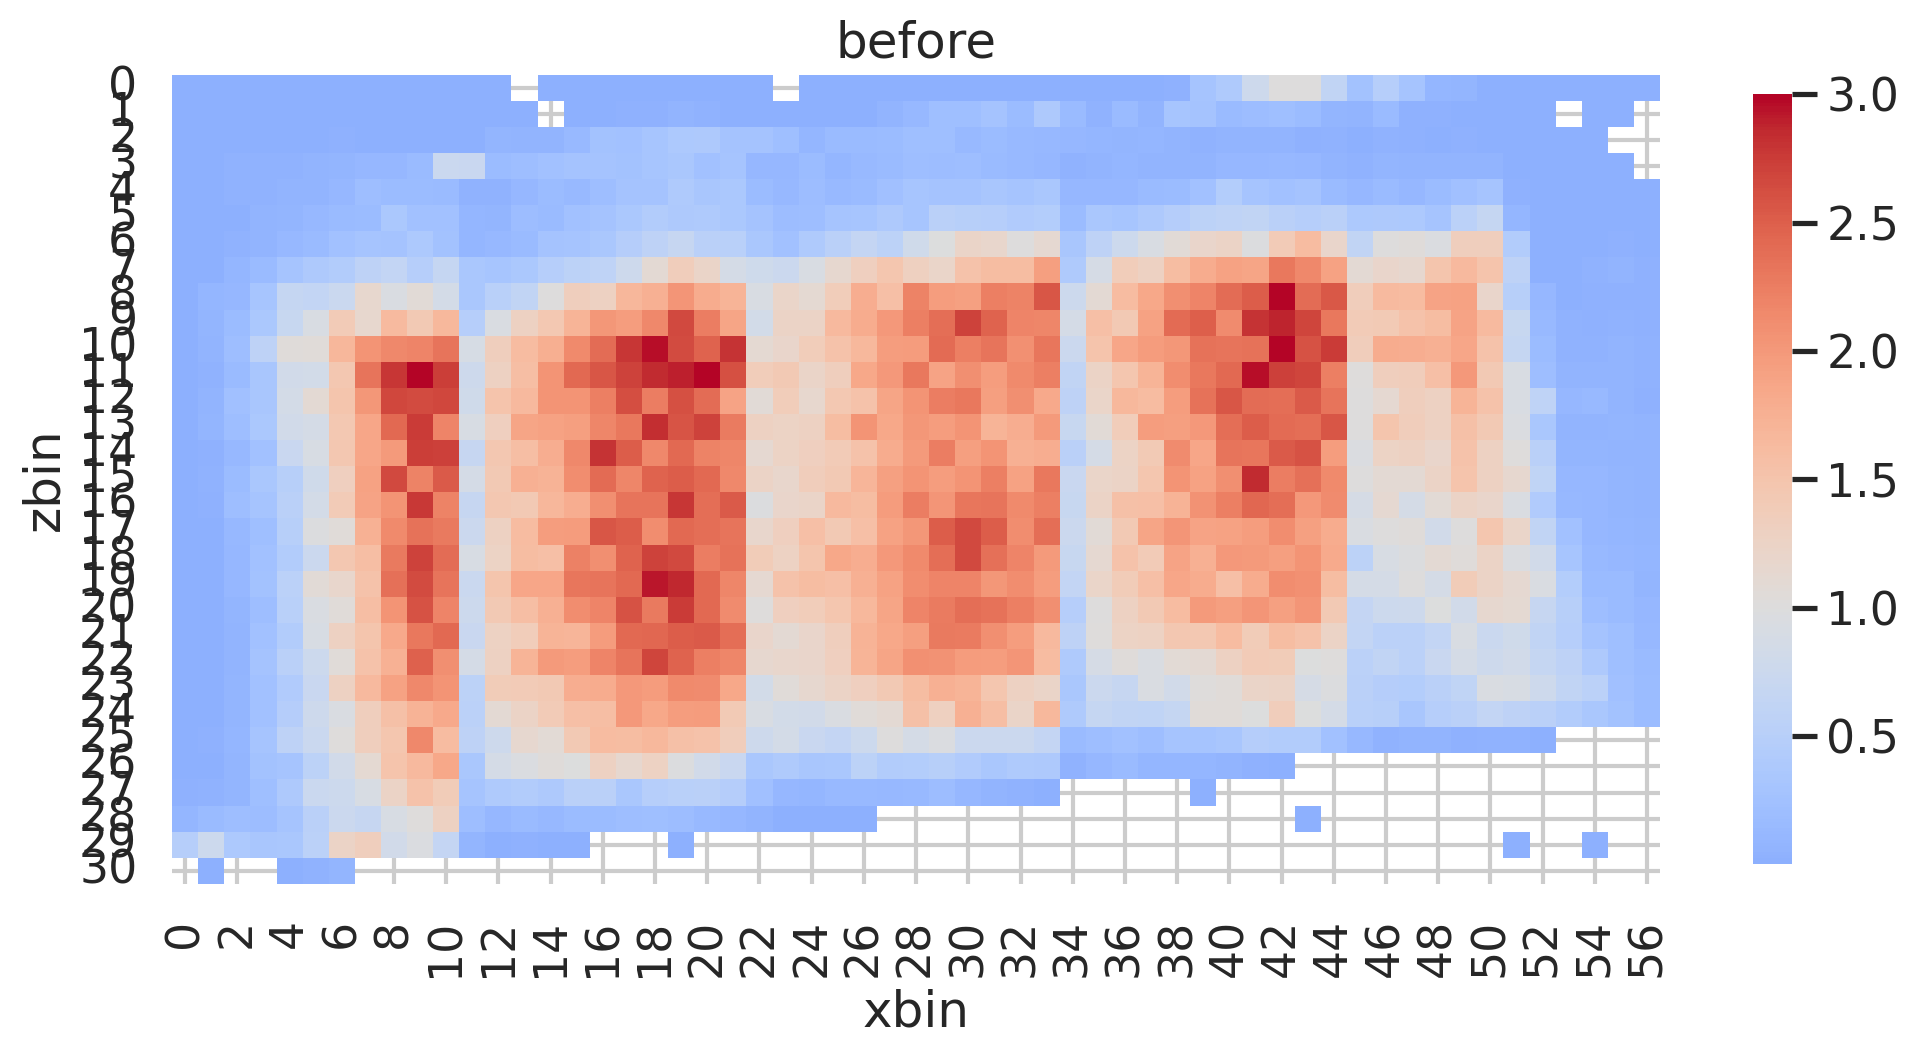

In [46]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
sns.heatmap(count1_xz/np.nanmean(count1_xz.values), ax=ax, cbar_kws=dict(shrink=0.5), cmap='coolwarm', center=1, vmax=3) #, vmax=2)
ax.set_aspect('equal')
ax.set_title('before')

Text(0.5, 1.0, 'before')

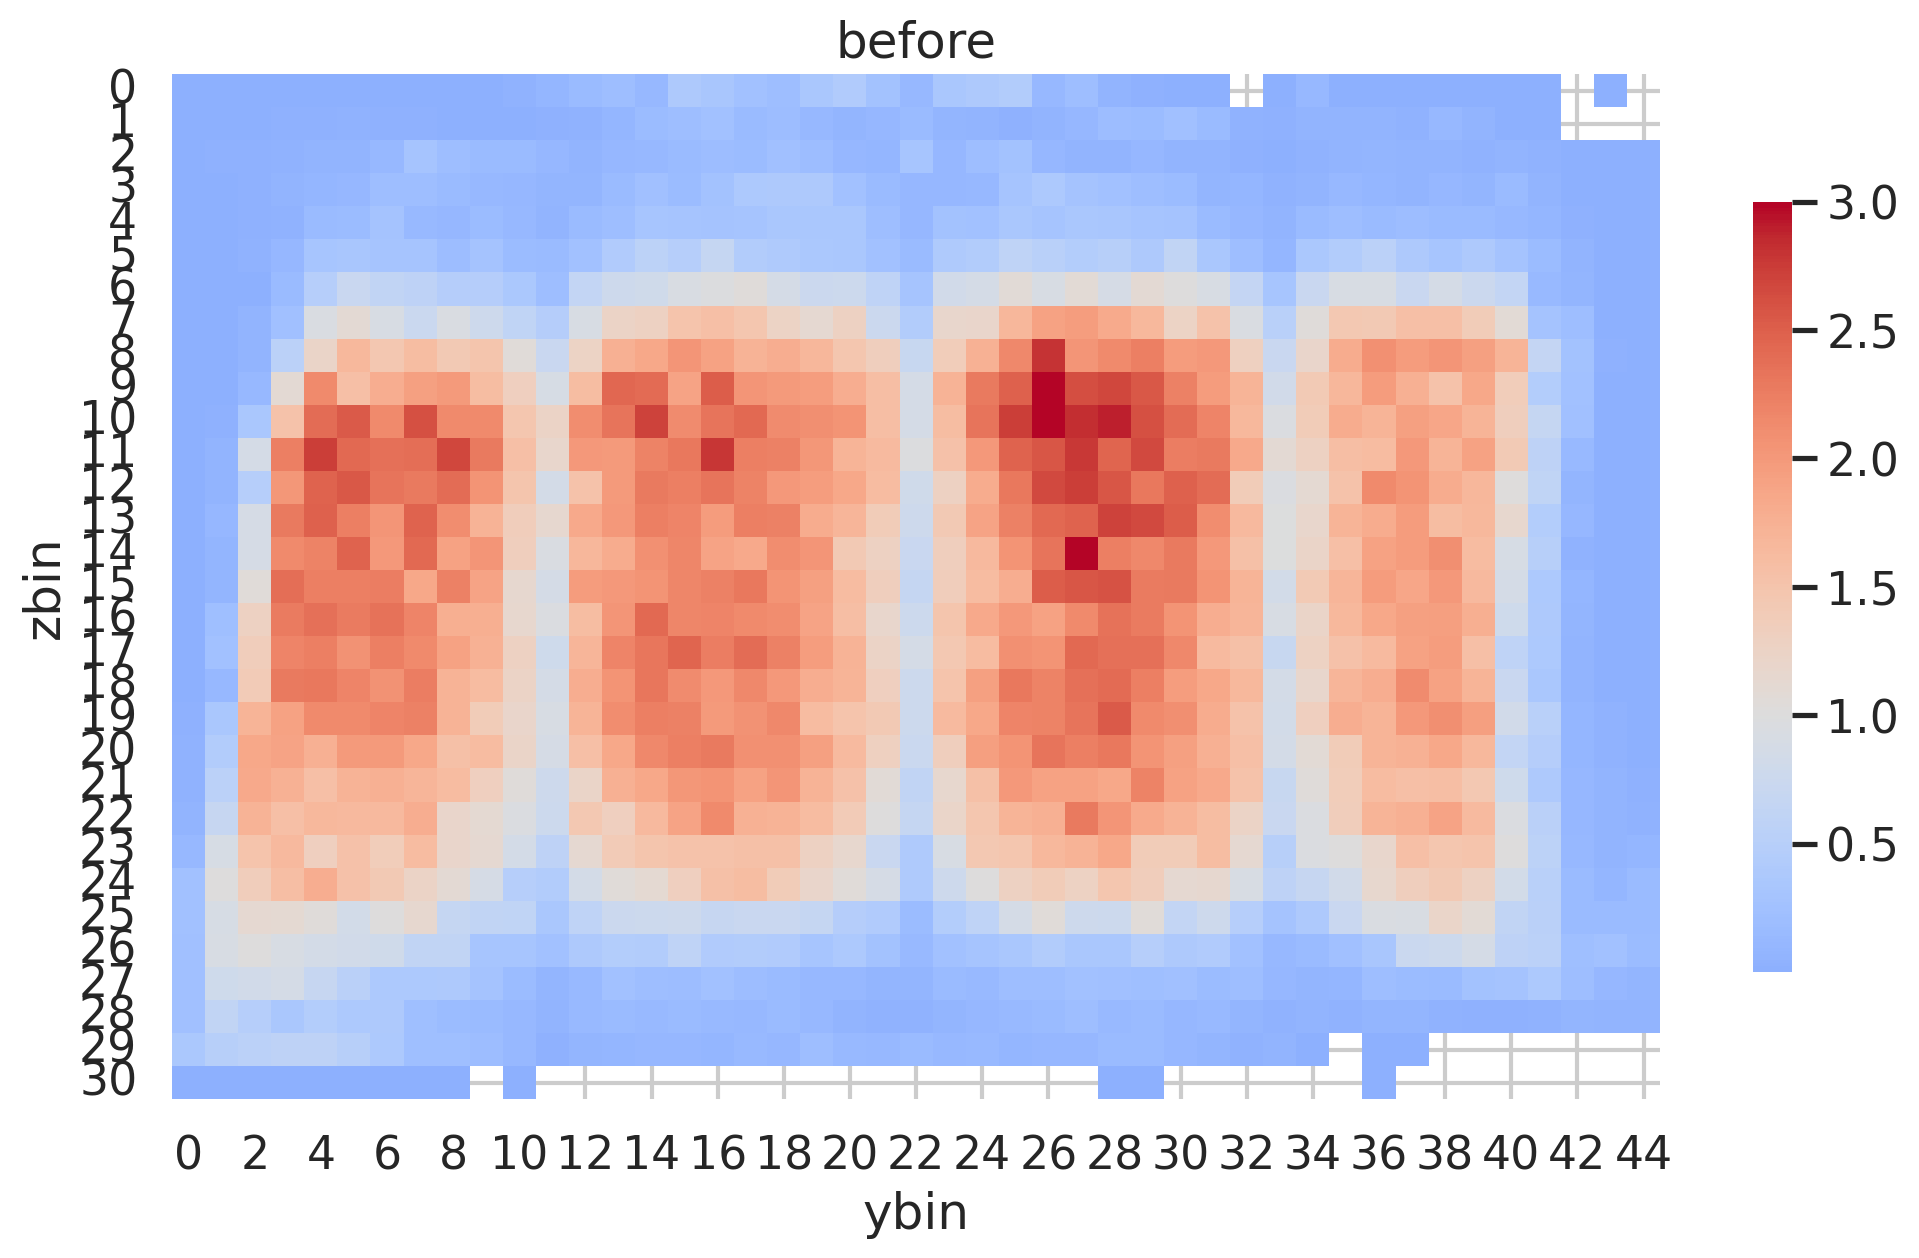

In [48]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
sns.heatmap(count1_yz/np.nanmean(count1_yz.values), ax=ax, cbar_kws=dict(shrink=0.5), cmap='coolwarm', center=1, vmax=3) #, vmax=2)
ax.set_aspect('equal')
ax.set_title('before')

In [ ]:
%%time
# output dir
if not os.path.isdir(output_dir):
    print(output_dir)
    os.mkdir(output_dir)
    
# image size in pixel (x, y, z)
grid = n5mu.read_voxel_grid(fix_dir, subpath)
# voxel resolution in µm (x, y, z) (post-expansion)
vox  = n5mu.read_voxel_spacing(fix_dir, subpath)
# image size in physical space (x, y, z) (post-expansion)
size = grid*vox
print('subpath: ', subpath)
print('voxel size: ', vox)
print('image size (pixel): ', grid)
print('image size (um post-ex): ', size)

# get image data
# print("loading images...")
# fix = zarr.open(store=zarr.N5Store(fix_dir), mode='r')     
# img1 = fix[subpath][:, :, :]

# get segmentation mask
lb = imread(lb_dir)
# roi = np.max(lb) # this is only correct if this lb is uncropped
roi = len(np.unique(lb[lb!=0])) # this would be better
print(lb.shape)
print('num roi: ', roi)

In [ ]:
# %%time
# bad_roi = []
# for reg_dir in reg_dirs:
#     reg = zarr.open(store=zarr.N5Store(reg_dir), mode='r')     
#     img2 = reg[subpath][...]
#     print("image loaded")
    
#     # get bad pixels -> bad roi
#     bad_roi_thisround = np.unique(lb[np.nonzero(img2==0)])
#     bad_roi.append(bad_roi_thisround)
#     print("# of ROIs rejected this round:", len(bad_roi_thisround))
    
# bad_roi = np.unique(np.hstack(bad_roi))
# print("# of ROIs rejected:", len(bad_roi))
# bad_roi

In [ ]:
%%time
# # Get list of ROIs that are fully or partially outside the mask 
### Make sure to only include ROIs that are intact and in the overlapping regions across all rounds of FISH
### remove any unregistered parts
if len(reg_dirs) > 0:
    mask = np.ones(grid[::-1])
    for reg_dir in reg_dirs:
        reg = zarr.open(store=zarr.N5Store(reg_dir), mode='r')     
        img2 = reg[subpath][...]
        print("image loaded")
        mask[img2==0]=0
    print("mask generated")

    bad_roi=np.unique(lb[mask==0])
    if bad_roi[0] == 0: # remove the label 0 - extracellular space
        bad_roi = bad_roi[1:]
    np.save(out_badroi, bad_roi)
    print("# of ROIs rejected:", len(bad_roi))

In [ ]:
%%time
# get cell locations (in um - pre-expansion) from segmentation mask
roi_meta_all = roi_prop.roi_prop_v2(lb, lb_res, ex)
roi_meta_all.to_csv(out_allroi)

roi_meta = roi_meta_all.set_index('roi').copy()
roi_meta = roi_meta #.loc[roi_meta.index.difference(bad_roi)]
roi_meta.to_csv(out_roi)

In [ ]:
%%time

# count spots for every cell (roi)

# all labels
lb_id = np.unique(lb[lb!=0]) # exclude 0
lb_id = np.hstack([[0], lb_id]) # include 0 - noncell
# selected cells
lb_id_selected = roi_meta.index.values

# prep
spotcount = pd.DataFrame(index=lb_id_selected, dtype=int)
# spotcount_intn = pd.DataFrame(index=lb_id_selected, dtype=float)

i = 0
for r,chs in round_channels.items():
    for c in chs:
        # f_intns = fx_intns[i]
        f_spots = fx_spots[i]
        intn_th = intn_threshs[i]
        print(r, c, f_spots) #, f_intns)

        # spots
        spots_rc = np.loadtxt(f_spots, delimiter=',')
        print(len(spots_rc))

        # filter
        filter_cond = spots_rc[:,3] > intn_th
        spots_rc = spots_rc[filter_cond]
        print(len(spots_rc))

        # count spots
        res = spot.spot_counts_worker(lb, spots_rc, lb_res,
                                      lb_id=lb_id, 
                                      remove_noncell=True, 
                                      selected_roi_list=lb_id_selected,
                                      )
        spotcount[f"{r}_{c}"] = res 

        # # count spots by intensity
        # res = spot.get_spot_counts_from_intn(f_intns, f_spots, roi_meta, lb_res)
        # spotcount_intn[f'{r}_{c}'] = res
        i = i + 1
    
# save results
spotcount.to_csv(out_spots)
# spotcount_intn.to_csv(out_spots_intn)

In [ ]:
# # reconcile two spot counts
# dist_cutoff = 2 # um pre-expansion
# density = spotcount.divide(roi_meta['area'], axis=0)
# cond = density < 1/(dist_cutoff**3) # keep spots if density is low

# print("# cells have high density: ", (~cond).sum()) 
# spotcount_merged = spotcount.where(cond, spotcount_intn)  # replace where the condition is False
# spotcount_merged.to_csv(out_spots_merged)
# spotcount_merged

In [ ]:
spotcount